# Creating an AI app that detects diseases in plants using Facebook’s deep learning platform: PyTorch

# Importing the libraries
First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here. The notebook was made on Google Colab.

In [1]:
# We need pillow version of 5.3.0
# We will uninstall the older version first
!pip uninstall -y Pillow
# Install the new one
!pip install Pillow==5.3.0
# Let's verify the version
# This should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime
!pip install image
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
import PIL
print(PIL.PILLOW_VERSION)

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl
5.3.0


In [2]:
# We will verify that GPU is enabled for this notebook
# Following should print: CUDA is available!  Training on GPU ...
# if it prints otherwise, then you need to enable GPU: 
# From Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:0


# Load the data

Here you'll use 'torchvision'  to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from 'torchvision' were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's ' [0.485, 0.456, 0.406]'  and for the standard deviations ''[0.229, 0.224, 0.225]' , calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:
# Download the dataset and unzip de folder
!gdown https://drive.google.com/uc?id=1Bhh3VeMBH6F7vKqHdDDmdyi-7RfvQNqJ
!tar -xvf PlantVillage.tar.gz

In [0]:
#Organizing the dataset
data_dir = '/PlantVillage'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
nThreads = 4
batch_size = 32
use_gpu = torch.cuda.is_available()

# Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the plant diseases.

In [0]:
import json

with open('categories.json', 'r') as f:
    cat_to_name = json.load(f)
    

In [0]:
# Define your transforms for the training and validation sets
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the datasets with ImageFolder

data_dir = 'PlantVillage'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# Using the image datasets and the trainforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features. Resnet-152 pretrained model is used for this image classifier.

In [0]:
# Build and train your network

# 1. Load resnet-152 pre-trained network
model = models.resnet152(pretrained=True)
# Freeze parameters so we don't backprop through them

for param in model.parameters():
    param.requires_grad = False

#Let's check the model architecture:
    print(model)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.torch/models/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:05<00:00, 45312575.77it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [0]:
# 2. Define a new, untrained feed-forward network as a classifier, using ReLU activations

# Our input_size matches the in_features of pretrained model


from collections import OrderedDict


# Creating the classifier ordered dictionary first

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(512, 39)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# Replacing the pretrained model classifier with our classifier
model.fc = classifier

In [0]:
#Function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
# Train a model with a pre-trained network
num_epochs = 10
if use_gpu:
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()

# NLLLoss because our output is LogSoftmax
criterion = nn.NLLLoss()

# Adam optimizer with a learning rate
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Using GPU: True
Epoch 1/10
----------
train Loss: 0.3281 Acc: 0.8968
val Loss: 0.1882 Acc: 0.9378

Epoch 2/10
----------
train Loss: 0.3199 Acc: 0.8986
val Loss: 0.1764 Acc: 0.9410

Epoch 3/10
----------
train Loss: 0.3139 Acc: 0.9001
val Loss: 0.1773 Acc: 0.9412

Epoch 4/10
----------
train Loss: 0.3062 Acc: 0.9017
val Loss: 0.2106 Acc: 0.9349

Epoch 5/10
----------
train Loss: 0.2948 Acc: 0.9064
val Loss: 0.1424 Acc: 0.9539

Epoch 6/10
----------


In [0]:
# Do validation on the test set
def test(model, dataloaders, device):
  model.eval()
  accuracy = 0
  
  model.to(device)
    
  for images, labels in dataloaders['val']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()
      
    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['val'])))



In [0]:
test(model, dataloaders, device)

Testing Accuracy: 0.003
Testing Accuracy: 0.006
Testing Accuracy: 0.008
Testing Accuracy: 0.011
Testing Accuracy: 0.014
Testing Accuracy: 0.017
Testing Accuracy: 0.020
Testing Accuracy: 0.023
Testing Accuracy: 0.026
Testing Accuracy: 0.028
Testing Accuracy: 0.031
Testing Accuracy: 0.034
Testing Accuracy: 0.037
Testing Accuracy: 0.040
Testing Accuracy: 0.043
Testing Accuracy: 0.045
Testing Accuracy: 0.048
Testing Accuracy: 0.051
Testing Accuracy: 0.054
Testing Accuracy: 0.056
Testing Accuracy: 0.059
Testing Accuracy: 0.062
Testing Accuracy: 0.065
Testing Accuracy: 0.067
Testing Accuracy: 0.070
Testing Accuracy: 0.073
Testing Accuracy: 0.076
Testing Accuracy: 0.079
Testing Accuracy: 0.082
Testing Accuracy: 0.085
Testing Accuracy: 0.087
Testing Accuracy: 0.090
Testing Accuracy: 0.093
Testing Accuracy: 0.096
Testing Accuracy: 0.099
Testing Accuracy: 0.101
Testing Accuracy: 0.104
Testing Accuracy: 0.107
Testing Accuracy: 0.110
Testing Accuracy: 0.112
Testing Accuracy: 0.115
Testing Accuracy

# Save the checkpoint

Now that the network is trained,  we will save the model so we can load it later for making predictions. We will save the mapping of classes to indices which we get from one of the image datasets: `image_datasets['train'].class_to_idx`. We will attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that we'll want to completely rebuild the model later so we can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
# Save the checkpoint 

model.class_to_idx = dataloaders['train'].dataset.class_to_idx
model.epochs = num_epochs
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 39,
                  'state_dict': model.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer.state_dict(),
                  'class_to_idx': model.class_to_idx,
                  'epoch': model.epochs}
torch.save(checkpoint, 'plants9615_checkpoint.pth')

# Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [10]:
#Download the trained model from here: 
!gdown https://drive.google.com/uc?id=1D3mWC5AAWlx3OdU4yljt7vtEPrpLFtmZ

Downloading...
From: https://drive.google.com/uc?id=1D3mWC5AAWlx3OdU4yljt7vtEPrpLFtmZ
To: /content/plants9615_checkpoint.pth
246MB [00:02, 102MB/s]


In [0]:
# Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.resnet152()
    
    # Our input_size matches the in_features of pretrained model
    input_size = 2048
    output_size = 39
    
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          #('dropout1', nn.Dropout(p=0.2)),
                          ('fc2', nn.Linear(512, 39)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# Replacing the pretrained model classifier with our classifier
    model.fc = classifier
    
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, checkpoint['class_to_idx']

# Get index to class mapping
loaded_model, class_to_idx = load_checkpoint('plants9615_checkpoint.pth')
idx_to_class = { v : k for k,v in class_to_idx.items()}

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the plant disease in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 


In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model

    size = 256, 256
    image.thumbnail(size, Image.ANTIALIAS)
    image = image.crop((128 - 112, 128 - 112, 128 + 112, 128 + 112))
    npImage = np.array(image)
    npImage = npImage/255.
        
    imgA = npImage[:,:,0]
    imgB = npImage[:,:,1]
    imgC = npImage[:,:,2]
    
    imgA = (imgA - 0.485)/(0.229) 
    imgB = (imgB - 0.456)/(0.224)
    imgC = (imgC - 0.406)/(0.225)
        
    npImage[:,:,0] = imgA
    npImage[:,:,1] = imgB
    npImage[:,:,2] = imgC
    
    npImage = np.transpose(npImage, (2,0,1))
    
    return npImage

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

# Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Implement the code to predict the class from an image file
    
    image = torch.FloatTensor([process_image(Image.open(image_path))])
    model.eval()
    output = model.forward(Variable(image))
    pobabilities = torch.exp(output).data.numpy()[0]
    

    top_idx = np.argsort(pobabilities)[-topk:][::-1] 
    top_class = [idx_to_class[x] for x in top_idx]
    top_probability = pobabilities[top_idx]

    return top_probability, top_class

In [15]:
print (predict('PlantVillage/val/Blueberry___healthy/06eacfab-fb39-40e0-bbce-927bc98fa2ac___RS_HL 2663.JPG', loaded_model))

(array([9.9871051e-01, 4.5131423e-04, 4.0855847e-04, 2.2177442e-04,
       6.1075392e-05], dtype=float32), ['Blueberry___healthy', 'Apple___Apple_scab', 'Apple___healthy', 'Peach___Bacterial_spot', 'Apple___Black_rot'])


# Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

You can convert from the class integer encoding to actual plant diseases names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
# Display an image along with the top 5 classes
def view_classify(img, probabilities, classes, mapper):
    ''' Function for viewing an image and it's predicted classes.
    '''
    img_filename = img.split('/')[-2]
    img = Image.open(img)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    flower_name = mapper[img_filename]
    
    ax1.set_title(flower_name)
    ax1.imshow(img)
    ax1.axis('off')
    
    y_pos = np.arange(len(probabilities))
    ax2.barh(y_pos, probabilities)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([mapper[x] for x in classes])
    ax2.invert_yaxis()

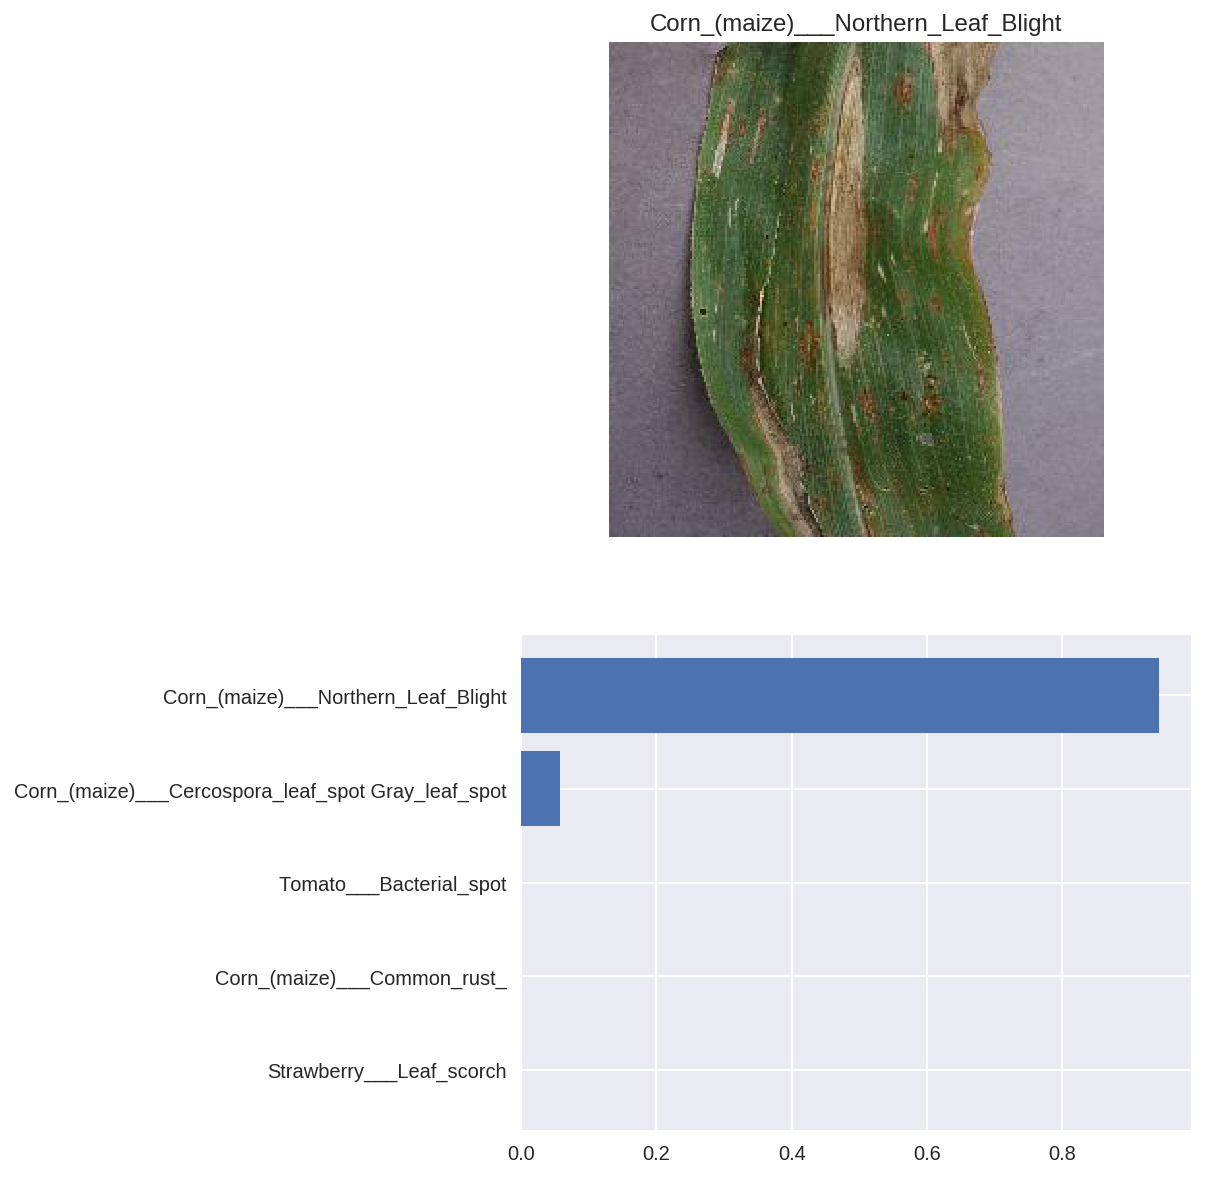

In [17]:
#img = 'PlantVillage/val/Apple___Black_rot/0139bc6d-391c-4fd1-bcae-cc74dabfddd7___JR_FrgE.S 2734.JPG'
#img = 'PlantVillage/val/Tomato___Bacterial_spot/00728f4d-83a0-49f1-87f8-374646fcda05___GCREC_Bact.Sp 6326.JPG'
img = 'PlantVillage/val/Corn_(maize)___Northern_Leaf_Blight/00a14441-7a62-4034-bc40-b196aeab2785___RS_NLB 3932.JPG'
#img = 'PlantVillage/val/Apple___healthy/3af9dc00-a64b-4b45-a034-1d190e5277ea___RS_HL 7788.JPG'
#img = 'PlantVillage/val/Potato___Late_blight/0acdc2b2-0dde-4073-8542-6fca275ab974___RS_LB 4857.JPG'
#img = 'PlantVillage/val/Tomato___Tomato_Yellow_Leaf_Curl_Virus/0e1fda76-d958-490f-9fcb-21e86c99dbe6___UF.GRC_YLCV_Lab 02200.JPG'

p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

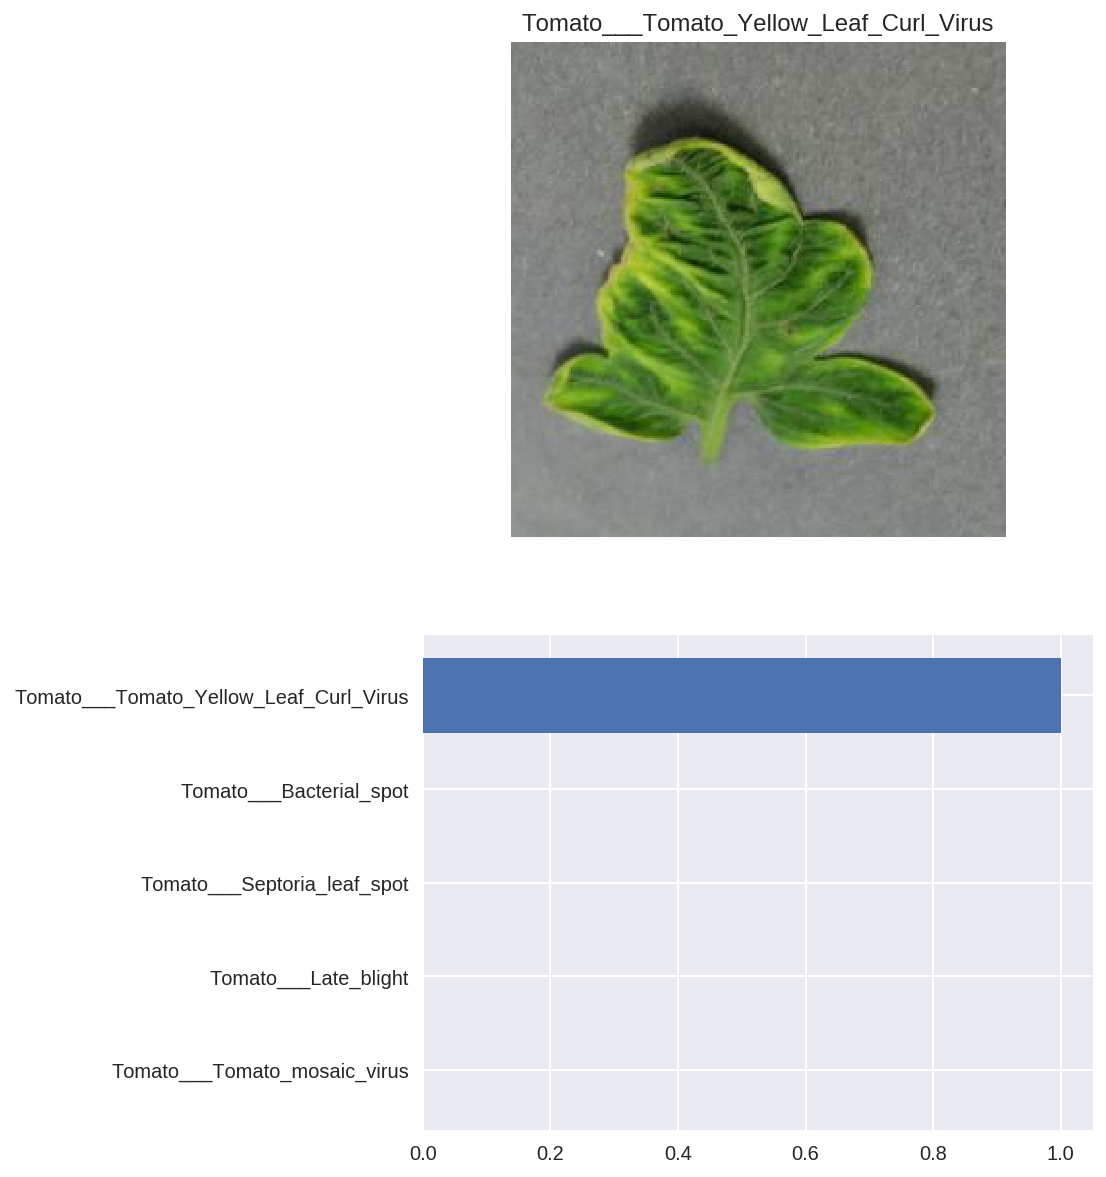

In [21]:
img = 'PlantVillage/val/Tomato___Tomato_Yellow_Leaf_Curl_Virus/0e1fda76-d958-490f-9fcb-21e86c99dbe6___UF.GRC_YLCV_Lab 02200.JPG'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

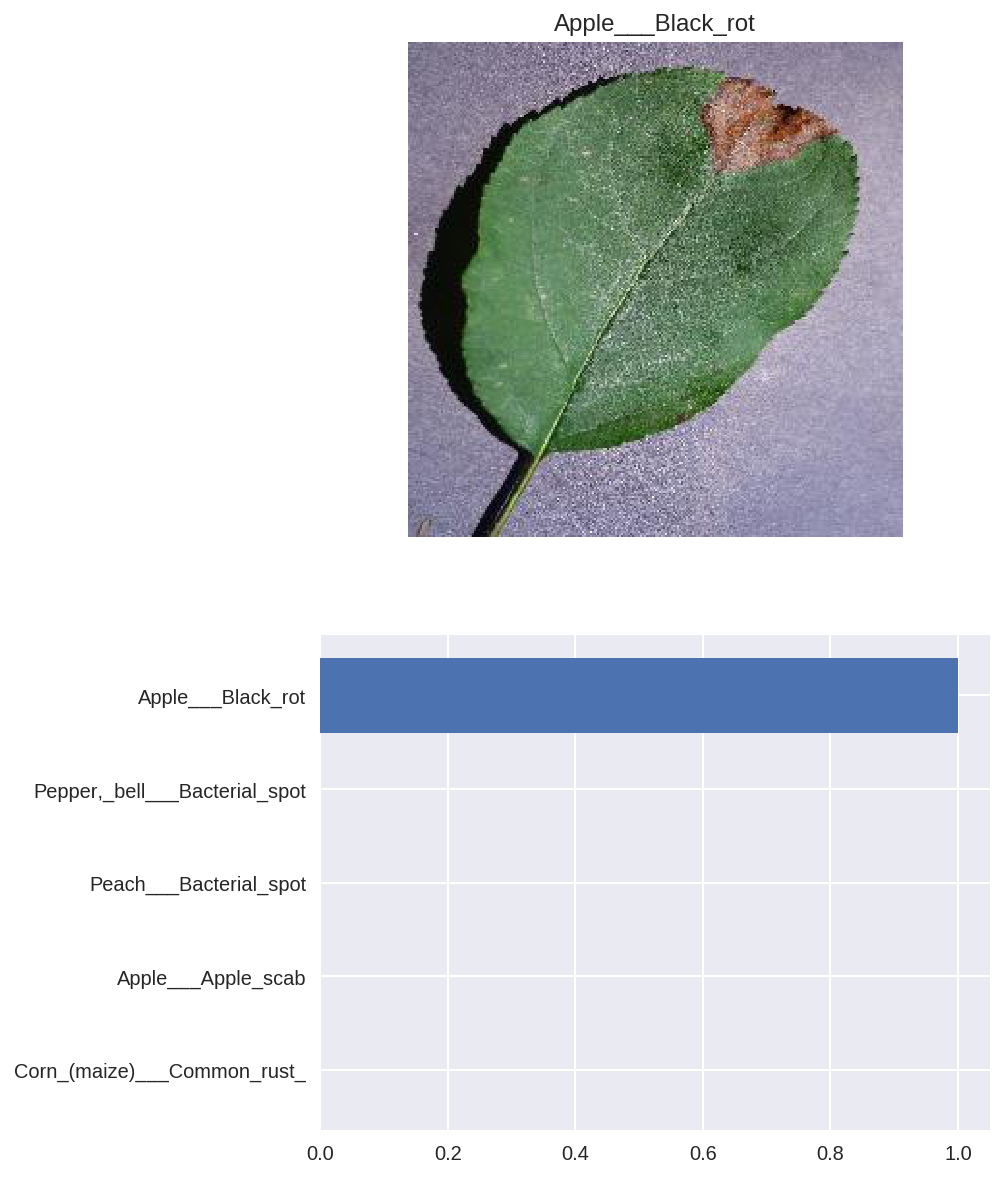

In [18]:
img = 'PlantVillage/val/Apple___Black_rot/0139bc6d-391c-4fd1-bcae-cc74dabfddd7___JR_FrgE.S 2734.JPG'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

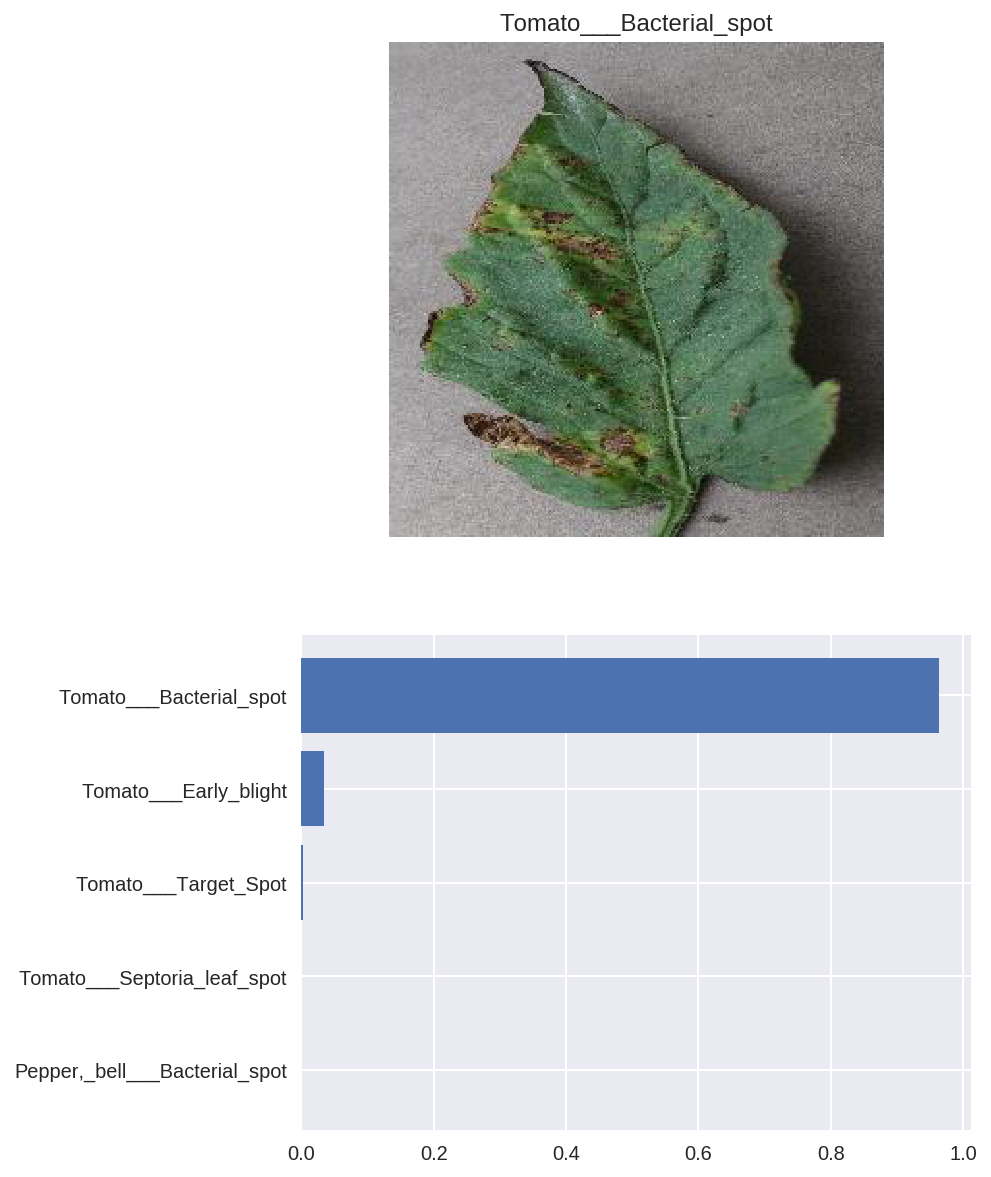

In [19]:
img = 'PlantVillage/val/Tomato___Bacterial_spot/00728f4d-83a0-49f1-87f8-374646fcda05___GCREC_Bact.Sp 6326.JPG'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

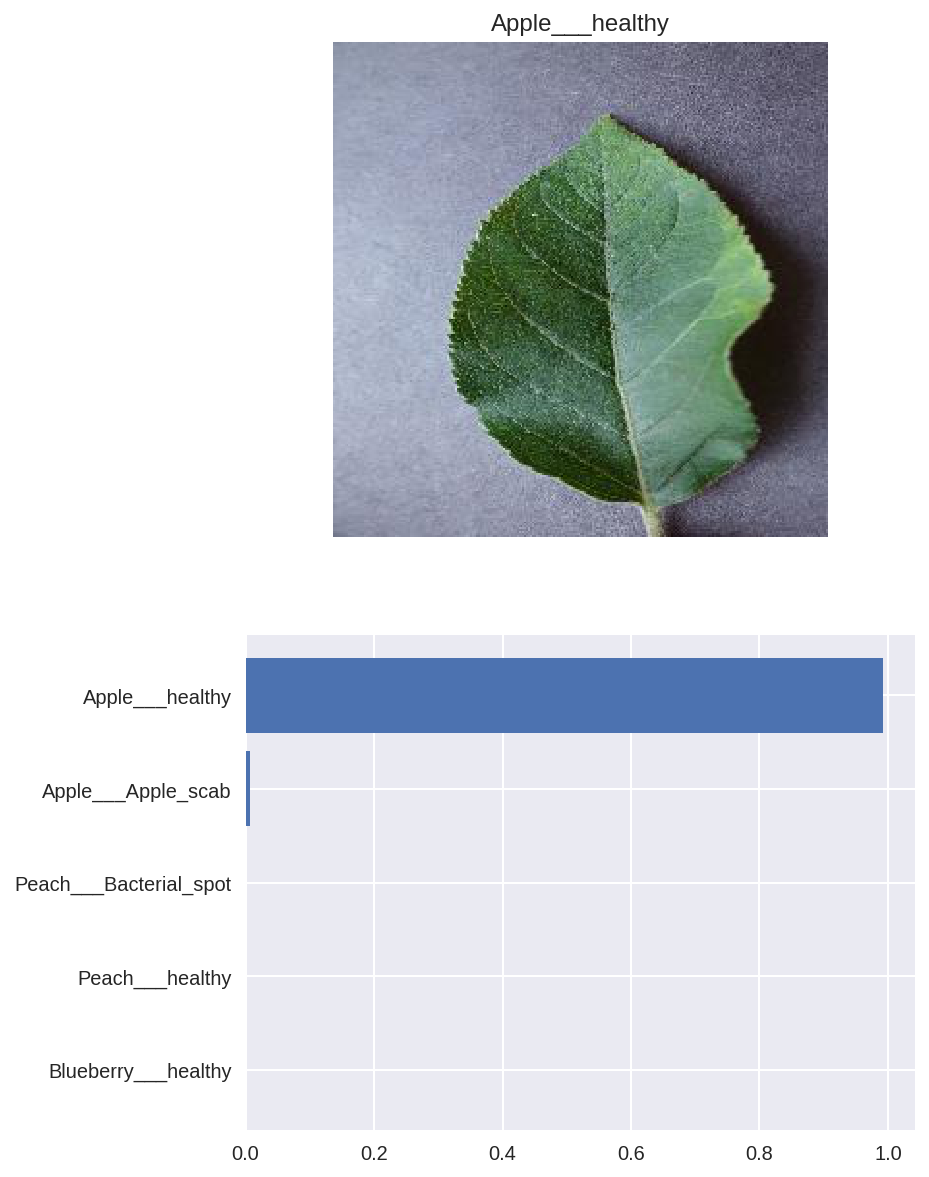

In [20]:
img = 'PlantVillage/val/Apple___healthy/3af9dc00-a64b-4b45-a034-1d190e5277ea___RS_HL 7788.JPG'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

# CONCLUSIONS

The model can be improved if you change some hyperparameters. You can try using a different pretrained model. It's up to you. Let me know if you can improve the accuracy!